In [1]:
import sys
import os
import matplotlib.pyplot as plt
from scipy.stats import linregress

lib_path = os.path.realpath(os.path.join(os.getcwd(), ".."))
if lib_path not in sys.path:
    sys.path = [lib_path] + sys.path

In [2]:
from src.main import *
from matplotlib import rc
from src.time_problem import TimeProblem
from src.plot_fields import Plotter

%matplotlib widget
rc("text", usetex=True)
rc("font", family="serif")
rc("figure", figsize=(10, 5))
rc("figure", dpi=100)
rc("font", size=18)
rc("legend", fontsize=16)
rc("text.latex", preamble=r"\usepackage{siunitx}")

In [3]:
dx = 0.06 / 5.0
phy_prop_no_conv = PhysicalProperties(
    Delta=1.0,
    v=0.0,
    dS=0.005**2,
    lda1=1.0,
    lda2=1.0,
    rho_cp1=1.0,
    rho_cp2=1.0,
    diff=0.0,
    alpha=0.06,
    a_i=357.0,
)
markers = Bulles(phy_prop=phy_prop_no_conv, n_bulle=1)
# print('I : ', bulle.indicatrice_liquide(x))
# print('If : ', bulle.indicatrice_liquide(xf))

In [4]:
dt_min_list = [
    10**-1,
    5.0 * 10**-2,
    2.0 * 10**-2,
    1.0 * 10**-2,
    5.0 * 10.0**-3,
    1.0 * 10**-3,
]
# dx_list = [0.06/25, 0.06/30, 0.06/50, 0.06/100, 0.06/150]
t0 = 5.0
n_lim = 10**7

In [5]:
def sinus(x, markers=None, phy_prop=None):
    return np.sin(x * 2 * np.pi)


def reference(t, x):
    return sinus(x) * np.exp(t)
    # return sinus(x) - t0 / (2. * np.pi) * (np.cos( 2. * np. pi * t / t0) - 1.)
    # return np.sin(x*2*np.pi) * np.exp(-t / (2.*np.pi))


# def terme_source(t, x, T):
#     return T

In [6]:
def test_cvgce_order():
    np.seterr(all="ignore")
    list_scheme = ["euler", "rk3"]
    list_labels = ["Euler", "Runge-Kutta 3"]
    fig, ax = plt.subplots(1)
    fig_prof, (ax_prof, ax_err) = plt.subplots(2, sharex="col", figsize=(10, 7))
    for i_scheme, scheme in enumerate(list_scheme):
        print("=================")
        print("| Schema temps: |")
        print("=================")
        print(scheme)
        err_schema = []
        dt_eff = []
        # figT, axT = plt.subplots(1)
        plotter = Plotter("decale", ispretty=True)
        for dt in dt_min_list:
            num_prop_schema = NumericalProperties(
                dx=dx,
                dt=dt,
                schema="weno",
                time_scheme=scheme,
                phy_prop=phy_prop_no_conv,
                cfl=1000,
                fo=10000,
            )
            prob_schema = TimeProblem(
                sinus,
                markers=markers,
                phy_prop=phy_prop_no_conv,
                num_prop=num_prop_schema,
                fonction_source=lambda t, x, T: T,
            )
            _, _ = prob_schema.timestep(
                t_fin=t0,
                n=n_lim,
                number_of_plots=1,
                plotter=plotter,
            )
            dt_eff.append(prob_schema.dt)
            error = np.abs(
                reference(prob_schema.problem_state.time, prob_schema.problem_state.x)
                - prob_schema.problem_state.T
            )
            err_schema.append(np.sqrt(np.mean(error**2.0)))
            if dt == dt_min_list[0]:
                ax_prof.plot(
                    prob_schema.problem_state.x,
                    prob_schema.problem_state.T,
                    label=list_labels[i_scheme] + r", $\Delta t = %g$" % prob_schema.dt,
                )
                ax_err.semilogy(prob_schema.problem_state.x, error)
        slope, intercept, r_value, p_value, std_err = linregress(
            np.log(dt_eff), np.log(err_schema)
        )
        print("Ordre : ", slope)
        print(r"$R^2$ : ", r_value**2)
        ax.loglog(
            dt_eff,
            err_schema,
            "-+",
            label=list_labels[i_scheme]
            + r", $\mathcal{O}(\Delta t^{%.3g})$" % (slope,)
            + r", $R^2 = %g$" % (r_value**2,),
        )
        ax.set_xlabel(r"$\Delta t$")
        ax.set_ylabel(
            r"$\epsilon = \frac{1}{L}\int_{L}{\left( T - T_{ref} \right)^2 dx}$"
        )
        ax.legend()
        ax.minorticks_on()
        ax.grid(visible=True, which="major")
        ax.grid(visible=True, which="minor", alpha=0.2)
        fig.tight_layout()

    ax_prof.plot(
        prob_schema.problem_state.x,
        reference(prob_schema.problem_state.time, prob_schema.problem_state.x),
        label=r"$T(x, t) = \sin(\frac{2\pi x}{L}) \exp(t)$",
    )
    ax_prof.legend()
    ax_prof.minorticks_on()
    ax_prof.grid(visible=True, which="major")
    ax_prof.grid(visible=True, which="minor", alpha=0.2)
    ax_err.minorticks_on()
    ax_err.grid(visible=True, which="major")
    ax_err.grid(visible=True, which="minor", alpha=0.2)
    ax_err.set_ylabel("Erreur")
    ax_prof.set_ylabel("Solution")
    ax_err.set_xlabel(r"$x$")
    ax_err.set_xlim(0.0, 1.0)
    ticks = np.linspace(0.0, 1.0, 10)
    ax_err.set_xticks(ticks, minor=False)
    ax_prof.set_xticks(ticks, minor=False)
    ax_err.set_xticklabels(
        [
            "0",
        ]
        + [
            "",
        ]
        * (len(ticks) - 2)
        + [
            "1",
        ],
        minor=False,
    )
    fig_prof.tight_layout()
    return fig, fig_prof

| Schema temps: |
euler

TOF
===
dt min
0.1
Db / dx = 04
Monofluid convection :  weno

TOF
===
dt min
0.05
Db / dx = 04
Monofluid convection :  weno

TOF
===
dt min
0.02
Db / dx = 04
Monofluid convection :  weno

TOF
===
dt min
0.01
Db / dx = 04
Monofluid convection :  weno

TOF
===
dt min
0.005
Db / dx = 04
Monofluid convection :  weno

TOF
===
dt min
0.001
Db / dx = 04
Monofluid convection :  weno
Ordre :  0.9646504695129252
$R^2$ :  0.9995230108029989
| Schema temps: |
rk3

TOF
===
dt min
0.1
Db / dx = 04
Monofluid convection :  weno

TOF
===
dt min
0.05
Db / dx = 04
Monofluid convection :  weno

TOF
===
dt min
0.02
Db / dx = 04
Monofluid convection :  weno

TOF
===
dt min
0.01
Db / dx = 04
Monofluid convection :  weno

TOF
===
dt min
0.005
Db / dx = 04
Monofluid convection :  weno

TOF
===
dt min
0.001
Db / dx = 04
Monofluid convection :  weno
Ordre :  2.9843284474808884
$R^2$ :  0.9999895964472576


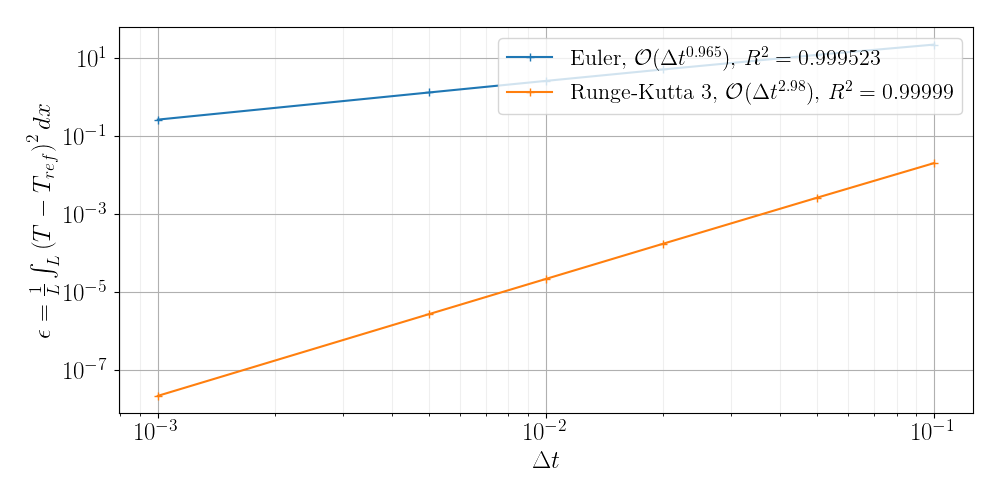

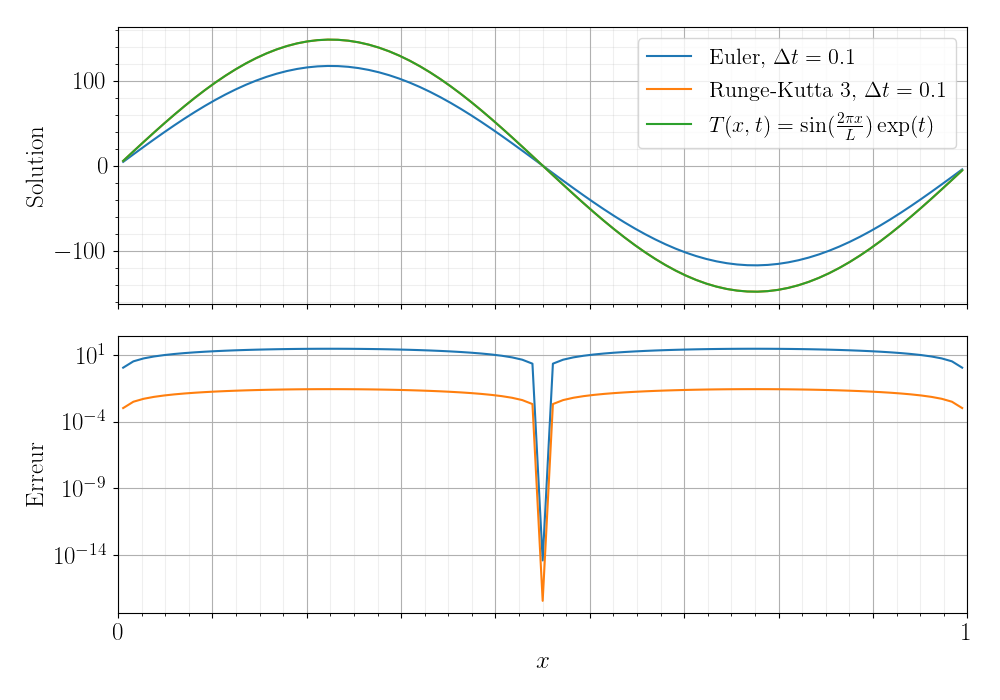

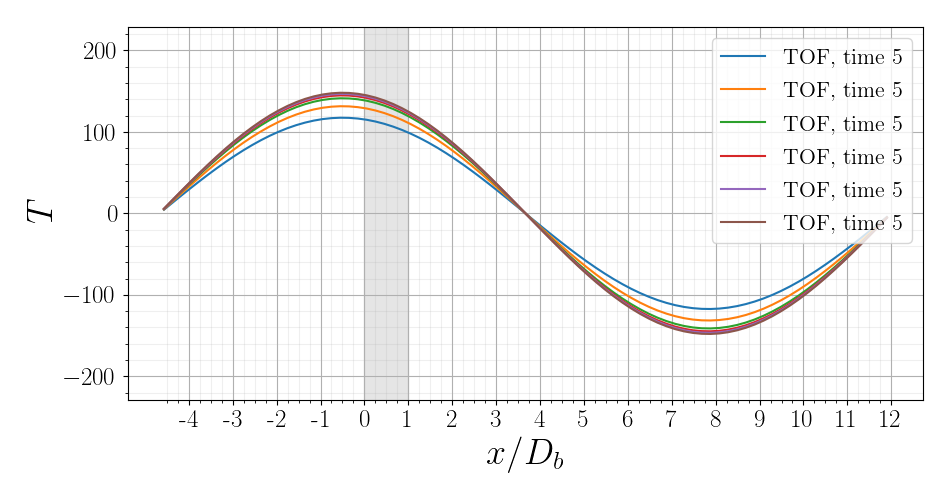

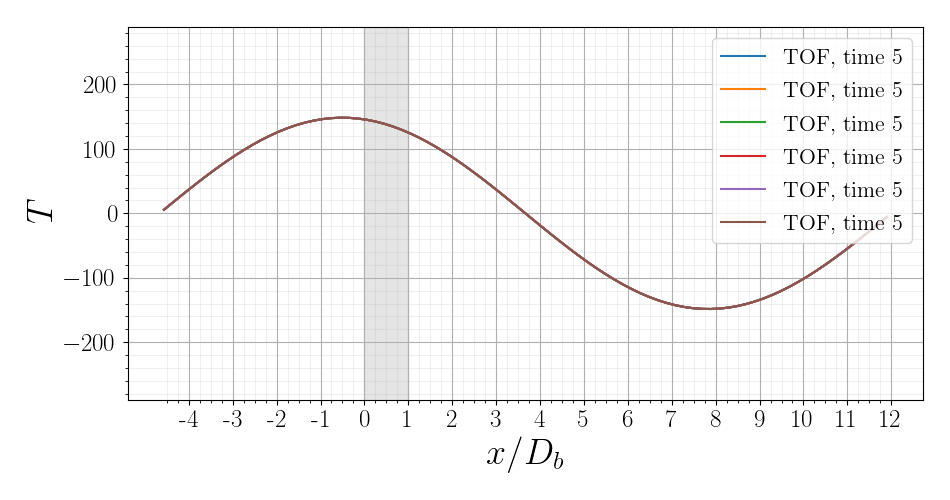

In [7]:
fig, fig_prof = test_cvgce_order()
# fig.savefig(os.path.join(os.getcwd(), '../figures/', 'convergence_schema_temps/', 'ordre_schemas_temps.pdf'))
# fig_prof.savefig(os.path.join(os.getcwd(), '../figures/', 'convergence_schema_temps/', 'profils_schemas_temps.pdf'))